In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *

from iterate import mycharray,interval_permute,mybin,weighted_sum,plot3dplot,binarize


In [2]:
data_path = Path('/data/cresswellclayec/DCA_ER/furano_periwal_prot')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER/furano_periwal_prot' # Set DCA_ER directory

data_dir = "%s/protein_data/" % DCA_ER_dir

In [3]:
colors = [(.71,.32,.8),(1.0,.65,0.),(.55,0.,0.),(0,.8,.8),(0.,.55,.55),\
                  (1.0,.1,.58),(0.,0.,.80),(0.4,0.4,0.4)]

In [4]:
all_seqs = []
with open('protein_data/all_seqs.fa', 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
        all_seqs.append(seq)

lp_msas = []
lp_fa_prefix = 'protein_data/'
lp_names = ['LPa1', 'LPa2', 'LPa3', 'LPa4', 'LPa5', 'LPa6', 'LPa7' ]
total_len = 0
lp_files = ['cls1.1.fasta','cls1.2.fasta','cls123.3.fasta','cls1ab234.4.fasta','cls123.5.fasta','cls1abc234.6.fasta','cls123.7.fasta']
lp_ids = []
for i,filename in enumerate(lp_files):
    lp_msas.append([])
    lp_ids.append([])
    print('Loading MSA for ',lp_names[i])
    with open(lp_fa_prefix+filename, 'rU') as f:
        seq_iter = SeqIO.parse(f,'fasta')
        for seq in seq_iter:
#             print(seq)
            lp_msas[-1].append(seq.seq) 
            lp_ids[-1].append(seq.id)
    f.close()
#     print(lp_msas[-1][0][:5])
    print(len(lp_msas[-1]))
    total_len += len(lp_msas[-1])
print('number of all individual LPa MSA sequences: ',total_len)
print('number of all aligned sequences: ',len(all_seqs))

Loading MSA for  LPa1
295
Loading MSA for  LPa2
499
Loading MSA for  LPa3
1000
Loading MSA for  LPa4
1104
Loading MSA for  LPa5
741
Loading MSA for  LPa6
599
Loading MSA for  LPa7
103
number of all individual LPa MSA sequences:  4341
number of all aligned sequences:  4341


In [5]:
family_ref = []
family_indx = []
for ii,ids in enumerate(lp_names):
    family_indx.append([])
for i,seq in enumerate(all_seqs):
    found = False
    for j,ids in enumerate(lp_ids):
        if seq.id in ids:
            family_ref.append(j)
            family_indx[j].append(i)
            found=True
            break
    if not found:
        print('could not categorize sequence!!')
        
family_ref = np.array(family_ref)
print('all familys contained?: ',np.unique(family_ref))
print('\nnumber of ids attributed to each family:')
for i in range(7):
    family_seqs = family_ref==i
    print(family_seqs.sum(axis=0))
    print(len(family_indx[i]))
family_colors = [colors[i] for i in family_ref]

all familys contained?:  [0 1 2 3 4 5 6]

number of ids attributed to each family:
295
295
499
499
1000
1000
1104
1104
741
741
599
599
103
103


In [6]:
s0 = np.array([seq.seq for seq in all_seqs])
print(s0.shape)

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
print('s0: ',s0.shape,'\n',s0)
s = onehot_encoder.fit_transform(s0)
print('s: ',s.shape,'\n',s)

(4341, 101)
s0:  (4341, 101) 
 [['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ...
 ['L' 'Y' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['F' 'C' '-' ... 'W' 'D' 'Y']]
s:  (4341, 1324) 
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
    
from sklearn.decomposition import PCA
pca_dim=3

pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


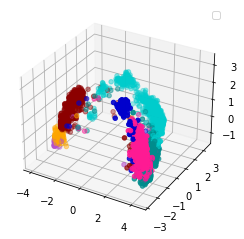

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], c=family_colors)
plt.legend()
plt.show()


## Generate w_ER

In [9]:

# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var


Number of residue positions: 101
Number of sequences: 4341
Number of different amino acids at each position [16 11  7 11 16 14 18 15 12 13 17 15 12 14 15 13 13 17 16 11 18 16 15 11
 17 12 12 11 12 14 16 16 12 13 22 13 16 18 13  9 13 12 10 15 13 15  1 13
 15  1 15 13 17 16 13 15 16 13  1 16 18 12 18 13 12 16 16 11 13 12 13 12
 13 14 12 12  9 14  1 12 16 13 14 11 12 12 14 13 12 14 14  7 14 13 13 10
 13 10 14 14 13]
Total number of variables 1324


In [10]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      
s_centered = s - s.mean(axis=0)      

s_train = s 
# Define wight matrix with variable for each possible amino acid at each sequence position               
w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
h0 = np.zeros(mx.sum())             

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        


w_file = "%s/w.npy" % (data_dir)        
# if os.path.exists(w_file) and not create_new:                                                          
if 0:                                                                                                    
    w_ER = np.load(w_file)                                                                               
else:                                                                                                    
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var))                                                                      
                                                                                                         
    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    
        
        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]
        
        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      
        
    # make w symmetric                                                                                   
    w_ER = (w_ER + w_ER.T)/2.                                                                            
    
    np.save(w_file, w_ER)


/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 56.604277300066315


In [11]:
from scipy.spatial import distance

def E(i1i2, s, w):
    E = 0
    s_len = len(i1i2)
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s[j1:j2]
            E += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E

print(E(i1i2, s[1,:], w_ER))


def energy_diff(i1i2, s1, s2, w):
    e_diff = 0.
    s_len = len(i1i2)

    E1 = E(i1i2, s1, w)
    E2 = E(i1i2, s2, w)
    #print(E1)
    #print(E2)
    
    e_diff1 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s1[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s2[j1:j2]
            e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    
    e_diff2 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s2[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s1[j1:j2]
            e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E1 + E2 - e_diff1 - e_diff2   


print('identity energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[1,:],w_ER))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[2,:],w_ER))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_train[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s_train[1,:],s_train[2,:]], 'hamming'))[0][1])

241.77123797820937
identity energy difference:  0.0
seq 1 vs 2 energy difference:  7.157086966823414
seq 1 vs seq2 hamming distance:  [[0.         0.01057402]
 [0.01057402 0.        ]]
0.010574018126888218


In [12]:
def PCA_perturb(seqs, pca, mag=1., pc_num=1, components=None):
    if components is None:
        dir_vec = pca.components_[pc_num] 
    else:
        dir_vec = components[pc_num]
    new_seqs =  seqs.copy()
    for i, seq in enumerate(seqs):
        new_seqs[i] = seqs[i] + mag * dir_vec
        
    return new_seqs



[-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]


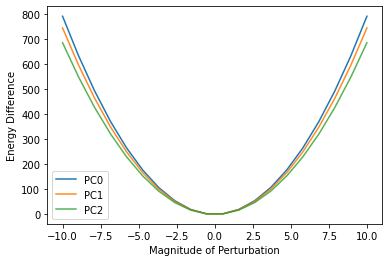

In [13]:
latent_dim = 3
pert_mags = np.linspace(-10,10, num=20)
print(pert_mags)
# get sequence set
sequence_set = s[:2]

# fit pca model to full sequence set: s_train
pca_perturb = PCA(n_components=latent_dim)
pca_perturb_s = pca_perturb.fit_transform(s) # do not pass s_centered to PCA, it will do that in-house


energy_vs_pc = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_pc.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_pc[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_pc[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [14]:
trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full[-1].append(trans_seq_full_out[0])  
print(np.array(trans_seq_full).shape)

(20, 3, 1324)


(4341, 1324)
(4341, 1324)
(4341, 3)
3
translated sequence full dim:  (3, 1324)
(10, 3, 3)
(10, 3, 3)


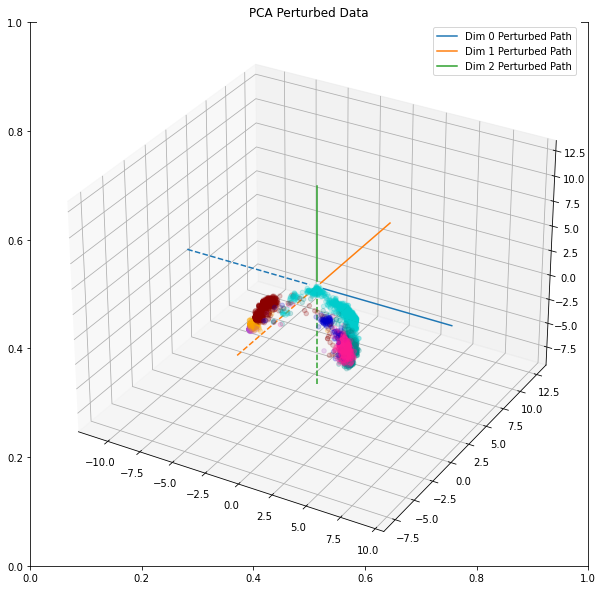

In [15]:

print(s_train.shape)
print(s.shape)
print(s_pca.shape)
perturb_path_full = np.array(trans_seq_full)
print(latent_dim)
print('translated sequence full dim: ', np.array(trans_seq_full[i]).shape)

perturb_path_mag = []
perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        perturb_path_mag.append(pca.transform(trans_seq_full[i]))
    else:
        perturb_path_mag_neg.append(pca.transform(trans_seq_full[i]))
perturb_path_mag = np.array(perturb_path_mag)
perturb_path_mag_neg = np.array(perturb_path_mag_neg)
print(perturb_path_mag.shape)
print(perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('PCA Perturbed Data')
ax = plt.axes(projection='3d')
ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], alpha=.2,c=family_colors)

dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

In [16]:
def ER_transform(seqs, v, mean=None):
    if mean is None:
        seqs_centered = seqs - np.mean(seqs,axis=0)
    else:
        seqs_centered = seqs - mean    
    new_seqs = seqs_centered @ v.T
    return new_seqs

def ER_inverse_transform(seqs, v):
    new_seqs = seqs @ v

    
# def ER_perturb(seqs, w, v, pert_mag=1.,mean=None, pert_dir=0):
#     dir_vec = v[pert_dir] 
    
#     # assumes sequences have not been centered
#     # if w is from subset of sequences you need to pass the mean of that subset
#     if mean is None:
#         seqs_centered = seqs - np.mean(seqs,axis=0)
#     else:
#         seqs_centered = seqs - mean
        
#     new_seqs =  seqs_centered.copy()
#     if len(new_seqs.shape)> 1:
#         for i, seq in enumerate(seqs_centered):
#             # print(np.add(seqs[i], pert_mag * dir_vec).shape)
#             new_seqs[i,:] = seq + pert_mag * dir_vec
#     else:
# #         new_seqs = np.add(seqs, pert_mag * dir_vec)
#         new_seqs = seqs + pert_mag * dir_vec
#     return new_seqs
def ER_perturb(seqs, w, v, pert_mag=1., pert_dir=0):
    dir_vec = v[pert_dir] 
    new_seqs =  seqs.copy()
    if len(new_seqs.shape)> 1:
        for i, seq in enumerate(seqs):
            # print(np.add(seqs[i], pert_mag * dir_vec).shape)
            new_seqs[i,:] = seq + pert_mag * dir_vec
    else:
#         new_seqs = np.add(seqs, pert_mag * dir_vec)
        new_seqs = seqs + pert_mag * dir_vec
    return new_seqs

In [17]:
w, v  = np.linalg.eig(w_ER)
print(w.shape)
print(v.shape)
print(w[:5])

trans_seq_full_out = ER_perturb(s[0], w, v, pert_mag=0, pert_dir=0)

print(sequence_set.shape)
print(trans_seq_full_out.shape)
print(sequence_set[0,:10])
print(trans_seq_full_out[:10])

(1324,)
(1324, 1324)
[8.55727545 7.94377491 7.512519   7.13448998 6.78575171]
(2, 1324)
(1324,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]


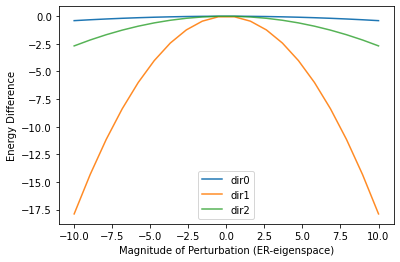

In [18]:
pert_mags = np.linspace(-10,10, num=20)
print(pert_mags)
ref_seq = s[0]

energy_vs_w_ERperturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ERperturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(ref_seq, w, v, pert_mag=mag, pert_dir=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out)  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ERperturb[-1].append(energy_diff(i1i2,trans_seq_full,ref_seq,w_ER))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ERperturb[i], alpha = 1-.1*i, label='dir%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (ER-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [19]:
wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out)  


(10, 3, 3)
(10, 3, 3)


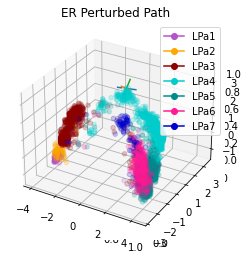

In [20]:
from matplotlib.lines import Line2D
wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(pca.transform(wER_trans_seq_full[i]))
    else:
        wER_perturb_path_mag_neg.append(pca.transform(wER_trans_seq_full[i]))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)

# creating figure
figg = plt.figure()
ax = figg.add_subplot(111, projection='3d')
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], alpha=.2,c=family_colors)
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]

# Create the figure
ax.legend(handles=legend_elements)
plt.show()

## Use w_ER-eig to transform space

In [21]:

s_ER = ER_transform(s,v)
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

(4341, 1324)
(10, 3, 1324)
(10, 3, 1324)


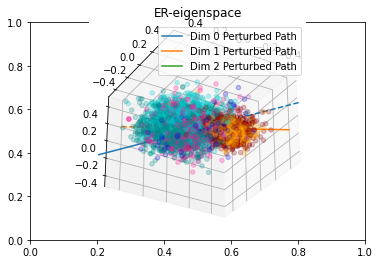

In [22]:

# print(w)
# print(v)
# v_stretch0 = v.copy()
# v_stretch0[0] = v[0]*1000
# s_ER = ER_transform(s,v_stretch0)

print(s_ER.shape)
pert_mags = np.linspace(-1,1, num=20)

wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out)  


wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(ER_transform(wER_trans_seq_full[i],v))
    else:
        wER_perturb_path_mag_neg.append(ER_transform(wER_trans_seq_full[i],v))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)

plt.title('ER-eigenspace')
ax = plt.axes(projection='3d')
ax.scatter(s_ER[:,0], s_ER[:,1], s_ER[:,2], alpha=.25,c=family_colors)
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')
ax.set_xlim3d(-.5, .5)
ax.set_zlim3d(-.5, .5)
ax.set_ylim3d(-.5, .5)
plt.legend()
# optimal viewing angle with change between generatinos of w_ER (fit function is stochastic)
ax.view_init(-30,60)

plt.show()
ax.view_init( )
plt.show()


In [23]:
import trimap
print(latent_dim)
trimap_embedder = trimap.TRIMAP(n_dims=3, n_iters=1000)
trimap_embedding = trimap_embedder.fit_transform(s)
print(len(s))
print(len(family_colors))

# print(s_E_dist.shape)
# trimap_ER_embedding = trimap.TRIMAP( use_dist_matrix=True, n_iters=1000).fit_transform(s_E_dist)
# trimap_hamming_embedding = trimap.TRIMAP(n_dims=3, distance='hamming',n_iters=1000).fit_transform(s_train[:100])

3
4341
4341


(4341, 3)


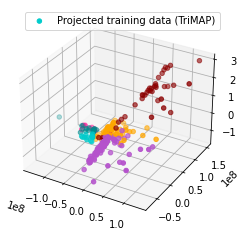

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
print(trimap_embedding.shape)
ax.scatter(trimap_embedding[:,0], trimap_embedding[:,1], trimap_embedding[:,2], c=family_colors, label='Projected training data (TriMAP)')
plt.legend()
plt.show()


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# print(trimap_embedding.shape)
# ax.scatter(trimap_ER_embedding[:,0], trimap_ER_embedding[:,1], trimap_ER_embedding[:,2], c=family_colors, alpha=0.1, label='Projected training data (TriMAP)')
# plt.legend()
# plt.show()

In [25]:
# Get W-er for all families
w_families = []
for msa_id in range(7):
    w_file = "%s/w_%s.npy" % (data_dir,lp_names[msa_id])        
    if os.path.exists(w_file):
        w_fam = np.load(w_file)
    else:
        w_fam = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum()) 
            #-------------------------------                                                                     
        # parallel  
        s_msa = s_train[family_indx[msa_id]]
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_msa,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('run time:',run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_fam[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_fam[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric                                                                                   
        w_fam = (w_fam + w_fam.T)/2.   
        np.save(w_file, w_fam)
    w_families.append(w_fam)


In [26]:
s_families = [] # list of full msa embeded in all family sequences spaces
for i,w_fam in enumerate(w_families):
    # get sequences space for family
    print(len(family_indx[i]))
    w_f, v_f  = np.linalg.eigh(w_fam)
    fam_mean = np.mean(s[family_indx[i]],axis=0)
    s_families.append(ER_transform(s,v_f, mean = fam_mean))


295
499
1000
1104
741
599
103


## Get two chrono-consecutive families in earliest group space 

LPa3
(4341, 1324)
(1000, 3)
(1104, 3)


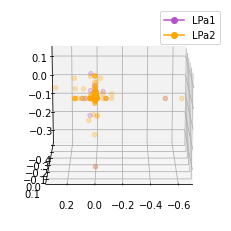

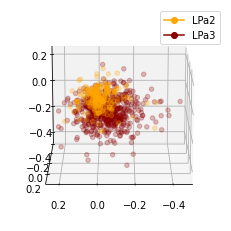

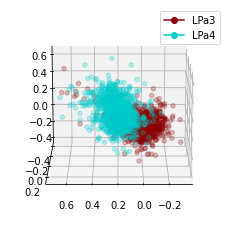

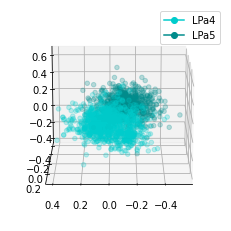

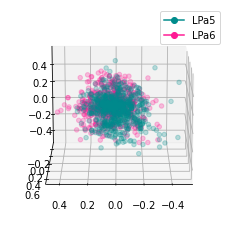

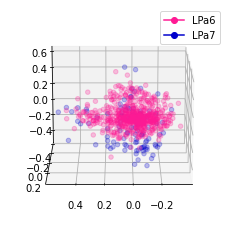

In [27]:
msa_1 = 2

gps = []
for ii, msa in enumerate(s_families):
    gps.append([])
    for i in range(len(s_families)):
        gps[-1].append(np.array(list(zip(msa[family_indx[i],0], msa[family_indx[i],1],msa[family_indx[i],2]))))
        
        
# gp1 = np.array(list(zip(s_families[msa_1][family_indx[msa_1],0], s_families[msa_1][family_indx[msa_1],1],s_families[msa_1][family_indx[msa_1],2])))
gp1 = gps[msa_1][msa_1]
print(lp_names[msa_1])
print(s_families[msa_1].shape)
print(gp1.shape)

msa_2 =msa_1+1
# gp2 = np.array(list(zip(s_families[msa_2][family_indx[msa_2],0], s_families[msa_2][family_indx[msa_2],1],s_families[msa_2][family_indx[msa_2],2])))
gp2 = gps[msa_1][msa_2]
print(gp2.shape)



legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]
for i in range(len(gps)-1):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    gp_a = gps[i][i]
    gp_b = gps[i][i+1]
    ax.scatter(gp_a[:,0], gp_a[:,1], gp_a[:,2],alpha=.25,color=colors[i])
    ax.scatter(gp_b[:,0], gp_b[:,1], gp_b[:,2],alpha=.25,color=colors[i+1])
#     ax.view_init(0,-65)   
    ax.view_init(15,90)  # wfam 2 ***

    ax.legend(handles=legend_elements[i:i+2])

          

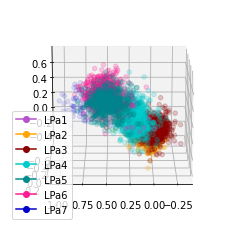

In [28]:
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(len(gps)-1):
    gp_a = gps[2][i]
    gp_b = gps[2][i+1]
    ax.scatter(gp_a[:,0], gp_a[:,1], gp_a[:,2],alpha=.1,color=colors[i])
    ax.scatter(gp_b[:,0], gp_b[:,1], gp_b[:,2],alpha=.1,color=colors[i+1])
#     ax.view_init(45,45)  # wfam 0
#     ax.view_init(45,45)  # wfam 1
    ax.view_init(15,90)  # wfam 2 ***
#     ax.view_init(0,-110)  # wfam 3
#     ax.view_init(15,-85)  # wfam 4
#     ax.view_init(45,95)  # wfam 5
#     ax.view_init(15,90)  # wfam 6

ax.legend(handles=legend_elements)

## Get separating plane and find gp1 point closest to it

In [29]:
from sklearn import svm
gp12 = np.append(gp1, gp2, axis=0)
y = np.zeros(len(gp12))
y[:len(gp1)] = 1
clf = svm.SVC(kernel='linear')
clf.fit(gp12,y)

def perp_dist(x1, y1, z1, a, b, c, d):
     
    d = abs((a * x1 + b * y1 + c * z1 + d))
    e = (math.sqrt(a * a + b * b + c * c))
    return d/e

    
import math
# min_dist = 100.
# print(len(gp1))
# for i, pt in enumerate(gp1):
#     pt_dist = perp_dist(pt[0],pt[1],pt[2], clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.intercept_[0])
#     if pt_dist < min_dist:
#         min_dist = pt_dist
#         min_id = i
# print(min_dist)
# print(min_id)

gp1_mean = np.mean(s[family_indx[msa_1]],axis=0)
# Get closest point to mean precursor
# Get closest point to mean precursor
    
from scipy.spatial.distance import pdist
min_dist = 100000.
print(len(gp1))
for i, msa2_seq in enumerate(s[family_indx[msa_2]]):

    pt_dist = pdist((gp1_mean,msa2_seq))
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = i
print(min_dist)
print(min_id)

1000
[3.78656097]
153


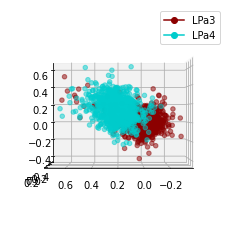

In [30]:
# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(svc.coef_[0], x) + b = 0. We should solve for the last coordinate
# to plot the plane in terms of x and y.

z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-.5,.5,51)
x,y = np.meshgrid(tmp,tmp)
# Plot stuff.
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z(x,y),alpha=.5)
ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.5,color=colors[msa_1])
ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.5,color=colors[msa_2])
ax.scatter(gp1[min_id,0],gp1[min_id,1],gp1[min_id,2],color='k',s=100)
ax.view_init(0,90)  
ax.legend(handles=legend_elements[msa_1:msa_2+1])

plt.show()

In [31]:
def check_angle(ref_pt, pt1, pt2):
    vec1 = pt1 - ref_pt
    vec2 = pt2 - ref_pt

    mag1 = np.sqrt(np.sum([a**2 for a in vec1]))
    mag2 = np.sqrt(np.sum([a**2 for a in vec2]))

    dot = np.dot(vec1, vec2)
    
    cos_theta = dot / (mag1 * mag2)
    
    return cos_theta

In [32]:
print(len(s_families[msa_1]))
print(len(s_families[msa_1][family_indx[msa_1]]))
boundary_seq = s_families[msa_1][family_indx[msa_2]][min_id]

# boundary_seq = s[family_indx[msa_1]][min_id]

n_dim = w_ER.shape[1]
wER_trans_boundary_seq = []

w, v  = np.linalg.eigh(w_families[msa_1])
print(w)
# for move_dim in range(n_dim):
#     wER_trans_boundary_seq.append([])
pert_mags = np.linspace(0,5., num=2)
print(pert_mags)
wER_pert = []
move_dim = n_dim-1



for i,mag in enumerate(pert_mags):
    print(mag)
    trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
#     wER_trans_boundary_seq[-1].append(trans_seq_full_out)  
    wER_pert.append(trans_seq_out)
print(len(wER_pert))

# wER_pert_trans = ER_transform(wER_pert,v)
wER_pert_trans = np.array(wER_pert)
print(len(wER_pert_trans))
print(len(wER_pert_trans[0]))

print(wER_pert_trans[0][0],wER_pert_trans[0][1],wER_pert_trans[0][2])
print(gp1[min_id,0],gp1[min_id,1],gp1[min_id,2])

4341
1000
[-4.22169248 -3.99250911 -3.1871524  ...  4.28214768  5.79066918
  6.60684762]
[0. 5.]
0.0
5.0
2
2
1324
0.008 0.009 0.004
0.10665723157868842 -0.11084943506953773 -0.018788384174547586


3


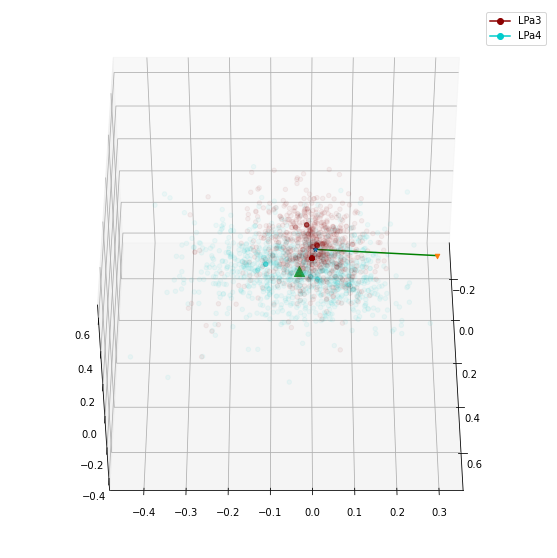

In [33]:

print(len(gp1[0]))

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z(x,y),alpha=.5)
ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.05,color=colors[msa_1])
ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.05,color=colors[msa_2])
ax.scatter(gp1_mean[0],gp1_mean[1],gp1_mean[2],marker='*',color='k')
ax.view_init(0,90)       
# ax.view_init(15,90)  # wfam 2 ***

ax.legend(handles=legend_elements[msa_1:msa_2+1])

ax.scatter(wER_pert_trans[0,0], wER_pert_trans[0,1], wER_pert_trans[0,2],marker='*')
gp2_mean = np.mean(gp2,axis=0)
    
cos_theta = check_angle(gp1_mean[:3], wER_pert_trans[-1,:3],boundary_seq[:3])
if cos_theta > 0.:        
    ax.plot(wER_pert_trans[:,0], wER_pert_trans[:,1], wER_pert_trans[:,2], color='g')
else:
    ax.plot(wER_pert_trans[:,0], wER_pert_trans[:,1], wER_pert_trans[:,2], color='r')
ax.scatter(wER_pert_trans[-1,0], wER_pert_trans[-1,1], wER_pert_trans[-1,2],marker='v')
ax.scatter(gp2_mean[0], gp2_mean[1], gp2_mean[2],marker='^',s=100)

ax.view_init(45,0)  
plt.show()

## Track the evolutionary path from one family to the next

295
[1.39223438]
7
295
499
[2.00161982]
21
499
1000
[3.78656097]
153
1000
1104
[3.72777647]
90
1104
741
[2.45349251]
403
741
599
[4.42659264]
73
599


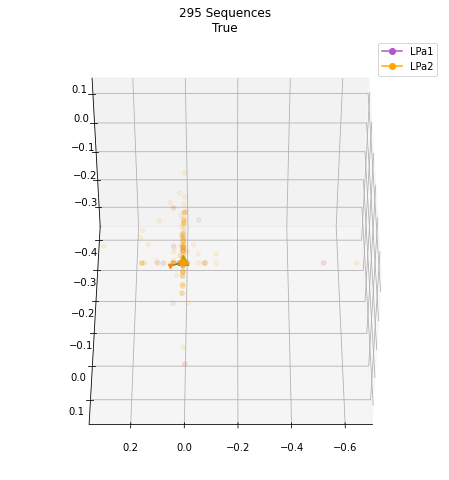

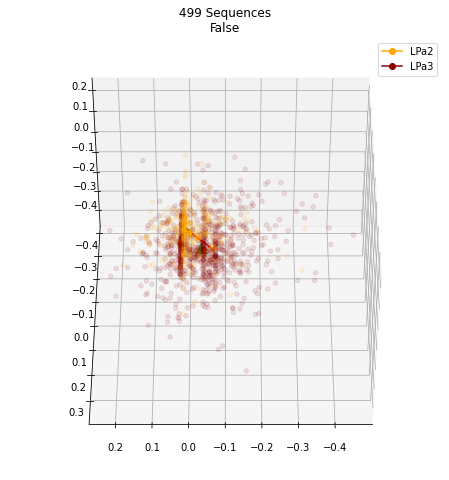

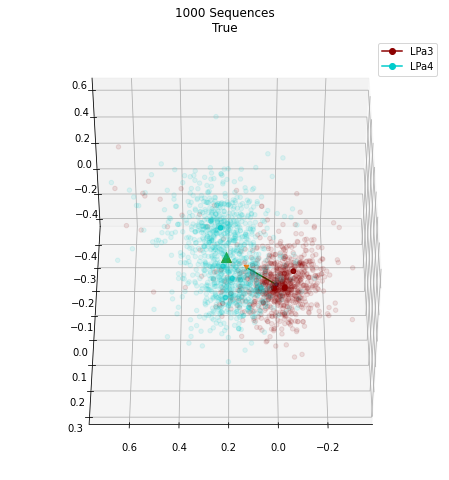

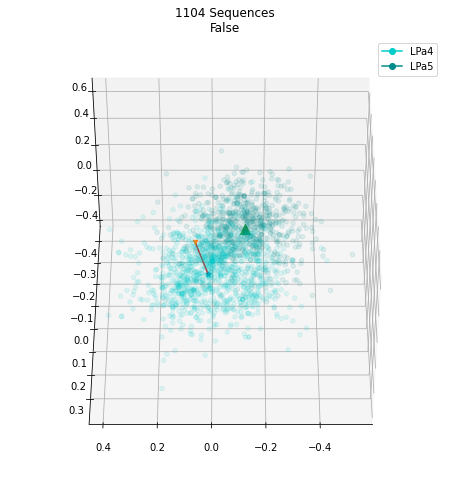

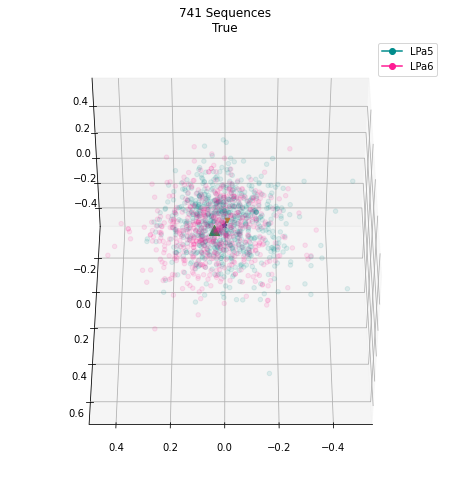

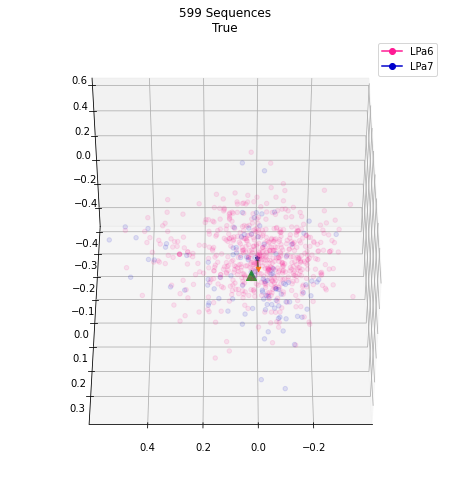

In [34]:
n_dim = w_ER.shape[1]
pert_mags = np.linspace(0,5., num=2)
move_dim = n_dim-1
move_dim = 0

for i in range(len(gps)-1):
#     # Get separating plane
    gp1 = gps[i][i]
    gp2 = gps[i][i+1]    
#     gp12 = np.append(gp1, gp2, axis=0)
#     y = np.zeros(len(gp12))
#     y[:len(gp1)] = 1
#     clf = svm.SVC(kernel='linear')
#     clf.fit(gp12,y)
    

#     z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

#     tmp = np.linspace(-.5,.5,51)
#     x,y = np.meshgrid(tmp,tmp)
    
#     # get closest precursor sequence to separating plane
#     min_dist = 100000.
#     for ii, pt in enumerate(gp1):
#         pt_dist = perp_dist(pt[0],pt[1],pt[2], clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.intercept_[0])
#         if pt_dist < min_dist:
#             min_dist = pt_dist
#             min_id = ii    


    gp1_mean = np.mean(s[family_indx[i]],axis=0)
    # Get closest point to mean precursor

    min_dist = 100000.
    print(len(gp1))
    for ii, msa2_seq in enumerate(s[family_indx[i+1]]):

        pt_dist = pdist((gp1_mean,msa2_seq))
        if pt_dist < min_dist:
            min_dist = pt_dist
            min_id = ii
    print(min_dist)
    print(min_id)

           
    # perturb closest precursor
    boundary_seq = s_families[i][family_indx[i+1]][min_id]

    wER_trans_boundary_seq = []

    w, v  = np.linalg.eigh(w_families[i])
    wER_pert = []
    for iii,mag in enumerate(pert_mags):
        trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_pert.append(trans_seq_out)
    wER_pert = np.array(wER_pert)

    
    # plot 
    print(len(gp1))
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.1,color=colors[i])
    ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.1,color=colors[i+1])
#     ax.view_init(0,-65)   
    ax.view_init(45,90)  # wfam 2 ***

    ax.legend(handles=legend_elements[i:i+2])
    ax.scatter(gp1_mean[0],gp1_mean[1],gp1_mean[2],marker='*',color='k')
    # ax.view_init(15,90)  # wfam 2 ***


    ax.scatter(wER_pert[0,0], wER_pert[0,1], wER_pert[0,2],marker='*')
    gp2_mean = np.mean(gp2,axis=0)

    cos_theta = check_angle(gp1_mean[:3], wER_pert_trans[-1,:3],boundary_seq[:3])
    if cos_theta > 0.:        
        ax.plot(wER_pert[:,0], wER_pert[:,1], wER_pert[:,2], color='g')
    else:
        ax.plot(wER_pert[:,0], wER_pert[:,1], wER_pert[:,2], color='r')

    ax.scatter(wER_pert[-1,0], wER_pert[-1,1], wER_pert[-1,2],marker='v')
    ax.scatter(gp2_mean[0], gp2_mean[1], gp2_mean[2],marker='^',s=100)
    ax.set_title('%s Sequences\n%s'%(len(gp1),str(cos_theta>0.)))
    
    

## Plot Iso-Energy Contours from reference sequence

In [35]:
msa_1 = 2

gps = []
for ii, msa in enumerate(s_families):
    gps.append([])
    for i in range(len(s_families)):
        gps[-1].append(np.array(list(zip(msa[family_indx[i],0], msa[family_indx[i],1],msa[family_indx[i],2]))))
        
        
# gp1 = np.array(list(zip(s_families[msa_1][family_indx[msa_1],0], s_families[msa_1][family_indx[msa_1],1],s_families[msa_1][family_indx[msa_1],2])))
gp1 = gps[msa_1][msa_1]
print(lp_names[msa_1])
print(s_families[msa_1].shape)
print(gp1.shape)

msa_2 =msa_1+1
# gp2 = np.array(list(zip(s_families[msa_2][family_indx[msa_2],0], s_families[msa_2][family_indx[msa_2],1],s_families[msa_2][family_indx[msa_2],2])))
gp2 = gps[msa_1][msa_2]
print(gp2.shape)

gp12 = np.append(gp1, gp2, axis=0)
max_x = max(gp12[:,0])
min_x = min(gp12[:,0])

max_y = max(gp12[:,1])
min_y = min(gp12[:,1])
print('max/min y/x: ', min_x,max_x,min_y,max_y)


LPa3
(4341, 1324)
(1000, 3)
(1104, 3)
max/min y/x:  -0.30465751034410216 0.6897197161006146 -0.428059677429551 0.2761733555721636


In [36]:
full_dist = np.load('furano_E_dist.npy')
print(full_dist.shape)

(4341, 4341)


In [50]:
# Get sequence energy difference between all sequences and the mean of gp1
gp12_indx = np.append(family_indx[msa_1], family_indx[msa_2], axis = 0)
print(gp12_indx.shape)
print(gp12_indx)

gp1_mean = np.mean(s[family_indx[msa_1]],axis=0)
w_gp1 = w_families[msa_1]
s_E_row = np.zeros(len(s))

(2104,)
[1898 1899 1900 ... 1101 1102 1103]


In [51]:
for i in range(len(s)):
    s_E_row[i] = energy_diff(i1i2,gp1_mean,s[i,:],w_gp1)
print(s_E_row)

[ 44.58647754  53.32099012  53.31816223 ... 208.35387121 190.36359302
 221.67304263]


In [55]:
# Get closest point to mean precursor

min_dist = 100000.
print(len(gp1))
for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):

    pt_dist = pdist((gp1_mean,msa2_seq))
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = ii
print(min_dist)
print(min_id)


# perturb closest precursor
boundary_seq = s_families[msa_1][family_indx[msa_2]][min_id]

wER_trans_boundary_seq = []

w, v  = np.linalg.eigh(w_gp1)
print(w)
wER_pert = []
move_dim = len(v)-1
for iii,mag in enumerate(pert_mags):
    trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
    wER_pert.append(trans_seq_out)
wER_pert = np.array(wER_pert)

1000
[3.78656097]
153
[-4.22169248 -3.99250911 -3.1871524  ...  4.28214768  5.79066918
  6.60684762]


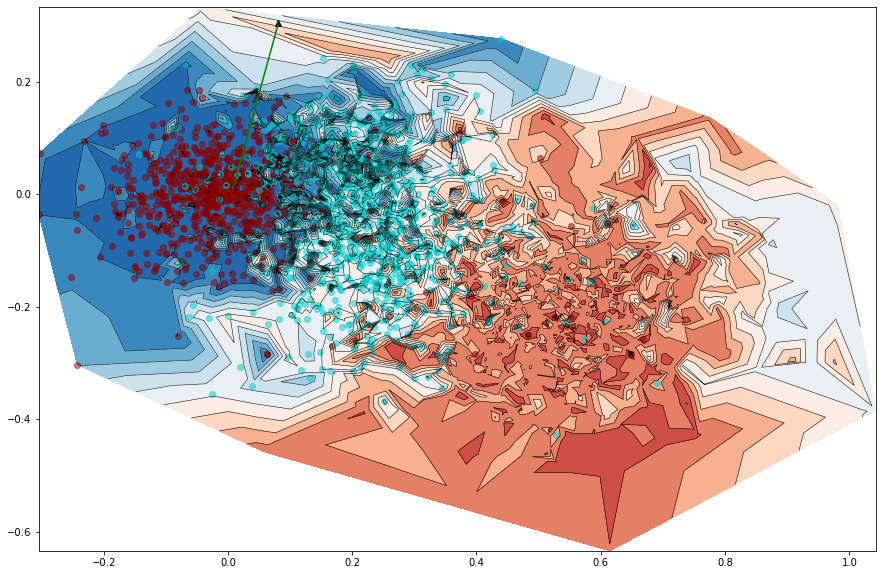

In [58]:
x = s_families[msa_1][:,0]
y = s_families[msa_1][:,1]
z = s_E_row

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)

ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

# fig.colorbar(cntr2, ax=ax)
ax.scatter(gp1[:,0], gp1[:,1],alpha=.5,color=colors[msa_1])
ax.scatter(gp2[:,0], gp2[:,1],alpha=.5,color=colors[msa_2])# ax.set(xlim=(-2, 2), ylim=(-2, 2))
# ax.set_title('tricontour (%d points)' % npts)
cos_theta = check_angle(gp1_mean[:2], wER_pert_trans[-1,:2],boundary_seq[:2])
if cos_theta > 0.:        
    ax.plot(wER_pert[:,0], wER_pert[:,1], color='g')
else:
    ax.plot(wER_pert[:,0], wER_pert[:,1], color='r')
ax.scatter(wER_pert[-1,0], wER_pert[-1,1],marker='^',color='k')
ax.scatter(gp1_mean[0], gp1_mean[1], marker='^',color=colors[msa_1],s=100)
ax.scatter(boundary_seq[0], boundary_seq[1], marker='*',color='k',s=100)

# plt.subplots_adjust(hspace=0.5)
plt.show()

original sequences shape:  (4341, 1324)
pca-embed:  (2, 1324)


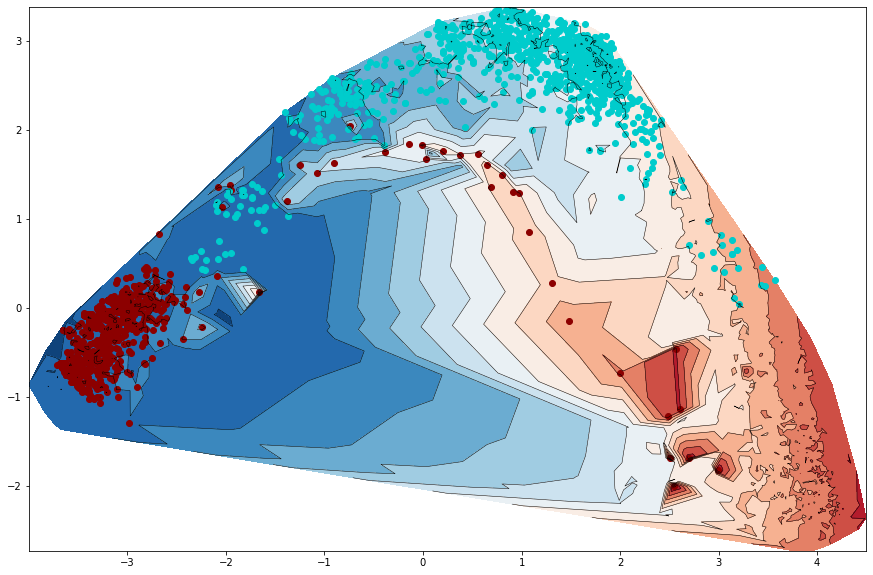

In [66]:
# PCA space contours.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)                                                                            
pca_s = pca.fit_transform(s)                                                                   
print('original sequences shape: ', s_train.shape)                                                   
print('pca-embed: ', pca.components_.shape)                                                          
                                                                                                     
                                                                                         
fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)
x = pca_s[:,0]
y = pca_s[:,1]
z = s_E_row
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2])                                                                               

plt.show()
    

In [67]:
gp2_mean = np.mean(s[family_indx[msa_2]],axis=0)
w_gp2 = w_families[msa_2]
s_E_row_post = np.zeros(len(s))
for i in range(len(s)):
    s_E_row_post[i] = energy_diff(i1i2,gp2_mean,s[i,:],w_gp1)
print(s_E_row_post)

[37.9751716  29.95350784 30.94727483 ... 63.82112641 50.18898479
 67.72132807]


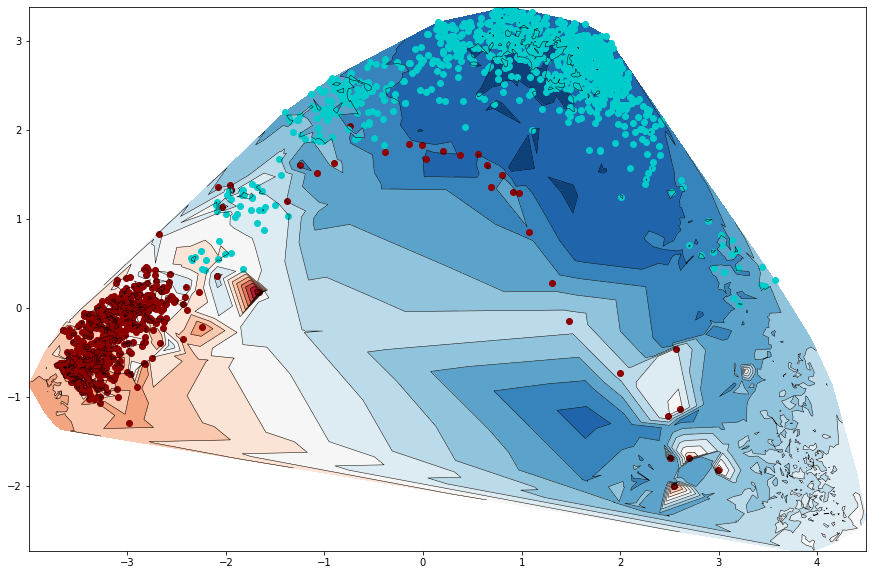

In [68]:
fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)
x = pca_s[:,0]
y = pca_s[:,1]
z = s_E_row_post
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2])                                                                               

plt.show()
    